In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
plt.rcParams['font.size'] = 14
#import pylab_util as PU
import os

In [8]:
def data_to_float_array(data):
    mylist = data.split('\n')
    clean_list = mylist#[3:]
    clean_2 = list(filter(None,clean_list))
    
    start_ind = None
    
    for i, row in enumerate(clean_2):
        if row.find("1,") == 0:
            start_ind = i
    
    end_ind = None
    
    for i, row in enumerate(clean_2):
        if row.find("input") > -1:
            end_ind = i
            
    clean_3 = clean_2[start_ind:end_ind]
    nested_list = [row.split(',') for row in clean_3]
    str_array = np.array(nested_list)
    float_array = str_array.astype(float)
    return float_array
    #return str_array

In [9]:
import control
#import digcomp

In [10]:
import serial
import serial_utils

In [11]:
import importlib

In [12]:
importlib.reload(serial_utils)

<module 'serial_utils' from '/Users/kraussry/Google Drive/Teaching/345/minisegways/SBR_git/serial_utils.py'>

In [54]:
import platform

In [55]:
plat_str = platform.platform().lower()
plat_str

'darwin-14.5.0-x86_64-i386-64bit'

In [56]:
myos = 'win'

if 'linux' in plat_str:
    myos = 'linux'
elif 'darwin' in plat_str:
    myos = 'mac'

print('myos: %s' % myos)

myos: mac


In [57]:
if myos == 'linux':
    portname = serial_utils.find_portname_RPi()
elif myos == 'mac':
    #portname = '/dev/tty.usbmodem1421'
    portname = '/dev/cu.usbmodem1421'
else:
    portname = 'COM3'
    
print('portname: %s' % portname)

portname: /dev/cu.usbmodem1421


In [101]:
ser = serial_utils.serial_test(portname)

In [102]:
ser.open()

In [103]:
ser.print_all()

motor testing v. 1.0.0
input test case




In [104]:
ser.flush()

In [105]:
ser.write_char("c")

In [106]:
ser.print_all()

getting ready to calibrate
calibration results:
276 396 312 400 308 312 
2500 2500 2500 2500 2500 2500 

input test case




In [108]:
ser.print_all()

In [116]:
ser.write_char("k")
ser.write_float(0.03)

In [117]:
ser.print_all()

kp = 0.0300
input test case




In [118]:
ser.write_char("n")
ser.write_float(50)

In [119]:
ser.print_all()

nom = 50
input test case

input test case

input test case

input test case

input test case

input test case




In [125]:
ser.write_char("1")
time.sleep(0.1)
data = ser.get_data()

In [88]:
data_array = data_to_float_array(data)

In [89]:
print(data)

#====================
kp=0.0500
#raw_loop_count,n_loop, t_ms, e, pwm1, pwm2, position
1,0.00,2898,0,0,102
2,4.94,2915,0,0,85
3,9.85,2915,0,0,85
4,14.76,2914,0,0,86
5,19.72,2914,0,0,86
6,24.69,2913,0,0,87
7,29.66,2915,0,0,85
8,34.62,2917,0,0,83
9,39.59,2900,0,0,100
10,44.61,2914,0,0,86
11,49.63,2914,0,145,86
12,54.76,2913,0,145,87
13,59.89,2913,0,145,87
14,65.02,2914,0,145,86
15,70.16,2910,0,145,90
16,75.31,2914,0,145,86
17,80.46,2913,0,145,87
18,85.61,2913,0,145,87
19,90.75,2915,0,145,85
20,95.91,2915,0,145,85
21,101.07,2915,0,145,85
22,106.26,2917,0,145,83
23,111.46,2915,0,145,85
24,116.66,2915,0,145,85
25,121.86,2917,0,145,83
26,127.06,2913,0,145,87
27,132.25,2924,0,146,76
28,137.46,2924,0,146,76
29,142.62,2930,0,146,70
30,147.84,2930,0,146,70
31,153.04,2929,0,146,71
32,158.23,2926,0,146,74
33,163.40,2930,0,146,70
34,168.60,2932,0,146,68
35,173.80,2932,0,146,68
36,179.01,2932,0,146,68
37,184.22,2932,0,146,68
38,189.44,2950,0,147,50
39,194.65,2948,0,147,52
40,199.86,2942,0,147,58
41,2

In [90]:
t_ms = data_array[:,1]
e = data_array[:,2]
pwm1 = data_array[:,3]
pwm2 = data_array[:,4]
pos = data_array[:,-1]
t = t_ms/1000

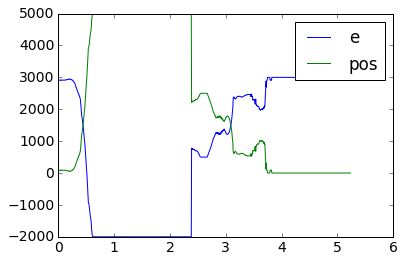

In [91]:
plt.figure()
plt.plot(t,e,t,pos)
plt.legend(['e','pos'])

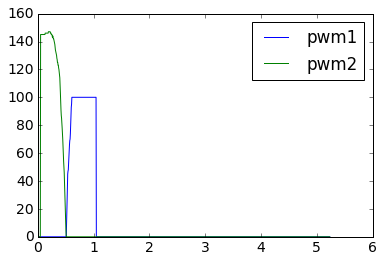

In [92]:
plt.figure()
plt.plot(t,pwm1,t,pwm2)
plt.legend(['pwm1','pwm2'])

In [80]:
ser.write_char("k")
ser.write_float(0.03)

In [81]:
ser.print_all()

kp = 0.0300
input test case


